# XGBoost Regression
- based on time features

In [122]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [123]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

## Data

In [111]:
cycling_data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))

In [112]:
def clean_data(data):
    '''Removes unnecessary columns, creates datetime index and total cyclists column'''
    data = data.copy()
    data["date_time"] = pd.to_datetime(data["DATUM_A_CAS"], errors="coerce")
    data["cyclists_total"] = data["POCET_DO"] + data["POCET_Z"]
    data = data.rename(columns={"NAZOV": "name", "POCET_DO": "direction_to", "POCET_Z": "direction_from"})


    columns = ["name", "date_time", "cyclists_total", "direction_to", "direction_from"]
    data = data[columns].sort_values(by="date_time")
    return data

In [113]:
data = clean_data(cycling_data)

In [114]:
# we will be using data including corona years
data_with_corona = data
data_after_corona = data[data["date_time"] >= "2022-01-01"]

In [115]:
def create_features(df):
    """Create time series features based on time index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    # cyclic notation for day of the week
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
    #is weekend
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    # spring/fall/summer/winter
    df['is_spring'] = df['month'].isin([3,4,5]).astype(int)
    df['is_summer'] = df['month'].isin([6,7,8]).astype(int)
    df['is_fall'] = df['month'].isin([9,10,11]).astype(int)
    df['is_winter'] = df['month'].isin([12,1,2]).astype(int)

    return df

In [116]:
data_with_features = create_features(data_with_corona.set_index('date_time'))

In [117]:
FEATURES_1 = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter']
# using cycling notation for the day of the week
FEATURES_2 = ['hour', 'dayofweek_sin','dayofweek_cos', 'quarter', 'month', 'year', 'dayofyear', 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter']
TARGET_TOTAL = 'cyclists_total'
TARGET_TO = 'direction_to'
TARGET_FROM = 'direction_from'

In [118]:
routes = list(data["name"].unique())

## Training and Validation

train/val/test split -- 60/20/20

In [119]:
results = []

In [120]:
for route in routes:
    print(f"=== ROUTE: {route} ===")
    for n_estimators in [500, 1000, 2000, 5000]:
        for learning_rate in [0.01, 0.05, 0.1, 0.9]:
            
            route_data = data_with_features[data_with_features["name"] == route].copy().sort_index()

            DATA = route_data

            TRAIN = DATA[:int(0.6*len(DATA))]
            VALIDATION = DATA[int(0.6*len(DATA)):int(0.8*len(DATA))]

            X_train = TRAIN[FEATURES_2]
            y_train = TRAIN[TARGET_TOTAL]

            X_val = VALIDATION[FEATURES_2]
            y_val = VALIDATION[TARGET_TOTAL]
            mean_val = y_val.mean()


            MODEL = xgb.XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                early_stopping_rounds=100,
                eval_metric="mae"
            )

            MODEL.fit(X_train, y_train,
                eval_set = [(X_train, y_train), (X_val, y_val)],
                verbose=False)
            
            best_mae = MODEL.best_score
            rel_mae = (best_mae / mean_val) * 100 if mean_val > 0 else 0

            results.append({
                'route': route,
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'model': MODEL,
                'best_val_score': best_mae,
                'rel_mae': rel_mae
            })

            print(f"Done: {route} | Najlepšie Rel. MAE v tomto kole: {rel_mae:.2f}% | MAE: {best_mae}")



=== ROUTE: Cyklomost Slobody ===
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 60.55% | MAE: 10.208422546488018
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 60.30% | MAE: 10.16603552035846
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 60.29% | MAE: 10.165009980774318
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 63.55% | MAE: 10.713715254175378
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 60.55% | MAE: 10.208422546488018
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 60.30% | MAE: 10.16603552035846
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 60.29% | MAE: 10.165009980774318
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 63.55% | MAE: 10.713715254175378
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 60.55% | MAE: 10.208422546488018
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tomto kole: 60.30% | MAE: 10.16603552035846
Done: Cyklomost Slobody | Najlepšie Rel. MAE v tom

In [ ]:
results_df = pd.DataFrame(results)

best_results_per_route = results_df.loc[results_df.groupby('route')['best_val_score'].idxmin()]

for _, row in best_results_per_route.iterrows():
    print(f"Route: {row['route']}, Best MAE: {row['best_val_score']:.4f}, n_estimators: {row['n_estimators']}, learning_rate: {row['learning_rate']}, RELATIVE MAE: {row['rel_mae']}")
    best_model_for_route = row['model']

### Visualizer for routes

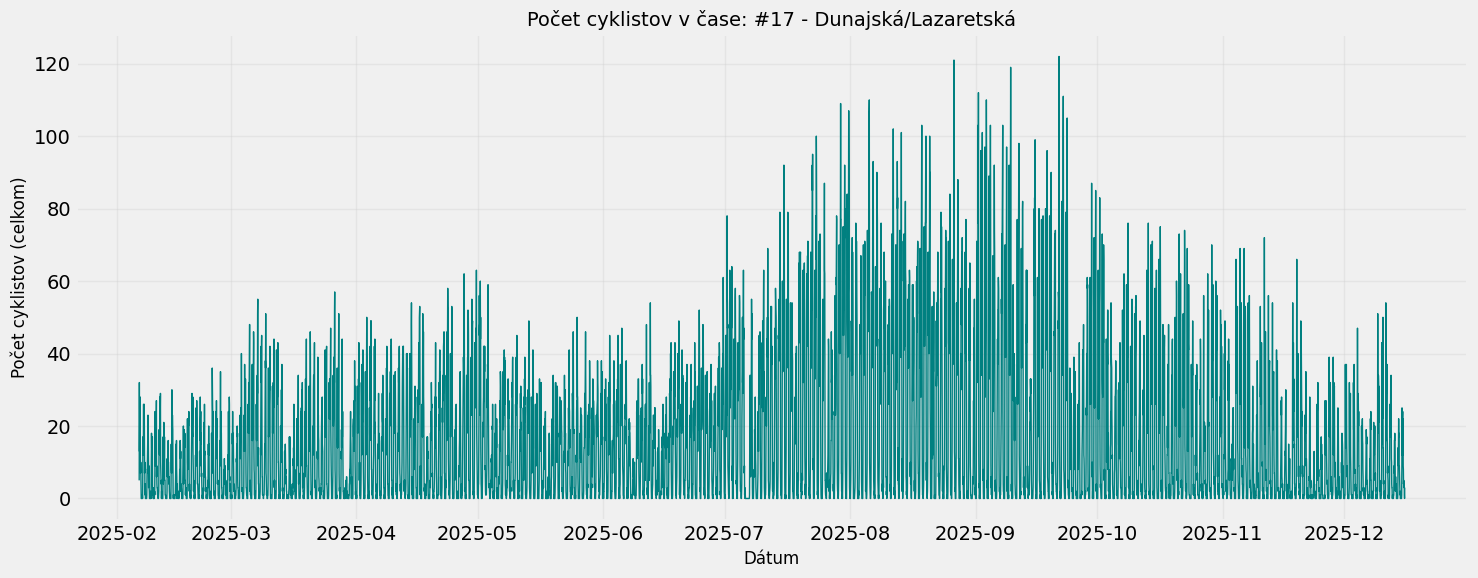

In [121]:
# for the purpose of revealing patterns in some routes (especially those with high rel. MAE)
route_name = "#5 - Devínska cesta"
route_name = '#15 - Incheba Einsteinova' 
route_name = "#16 - Trenčianska" 
route_name = '#17 - Dunajská/Lazaretská'

plot_data = data_with_features[data_with_features["name"] == route_name].sort_index()

plt.figure(figsize=(15, 6))
plt.plot(plot_data.index, plot_data['cyclists_total'], color='teal', linewidth=1)

plt.title(f'Počet cyklistov v čase: {route_name}', fontsize=14)
plt.xlabel('Dátum', fontsize=12)
plt.ylabel('Počet cyklistov (celkom)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Feature importance

In [101]:
plt.style.use('default')

**Global Feature Importance**

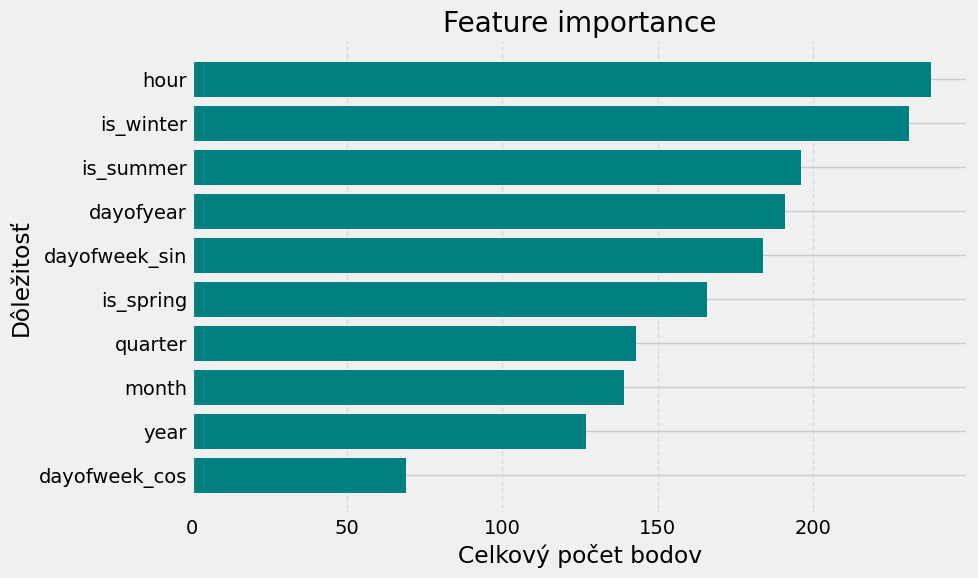

In [ ]:
feature_scores = {}

for _, row in best_results_per_route.iterrows():
    model = row['model']
    
    importance = model.get_booster().get_score(importance_type='gain')
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Bodovanie: 1. miesto = 13 bodov (lebo 12 features), 2. miesto = 12 bodov ... až po 1 bod
    for rank, (feature, score) in enumerate(sorted_features[:10]):
        points = 13 - rank
        if points > 0:
            feature_scores[feature] = feature_scores.get(feature, 0) + points


summary_importance = pd.DataFrame({
    'feature': feature_scores.keys(),
    'total_points': feature_scores.values()
}).sort_values(by='total_points', ascending=True)


plt.figure(figsize=(10, 6))
plt.barh(summary_importance['feature'].tail(10), summary_importance['total_points'].tail(10), color='teal')
plt.title('Feature importance')
plt.xlabel('Celkový počet bodov')
plt.ylabel('Dôležitosť')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



**Local Feature Importance**

In [102]:
importance_matrix = []

for _, row in best_results_per_route.iterrows():
    model = row['model']
    route = row['route']
    
    importance = model.get_booster().get_score(importance_type='gain')
    
    for feature, gain in importance.items():
        importance_matrix.append({
            'route': route,
            'feature': feature,
            'gain': gain
        })

importance_df = pd.DataFrame(importance_matrix)


In [103]:
pivot = importance_df.pivot_table(
    index='feature',
    columns='route',
    values='gain',
    fill_value=0
)

pivot_norm = pivot / pivot.sum(axis=0)


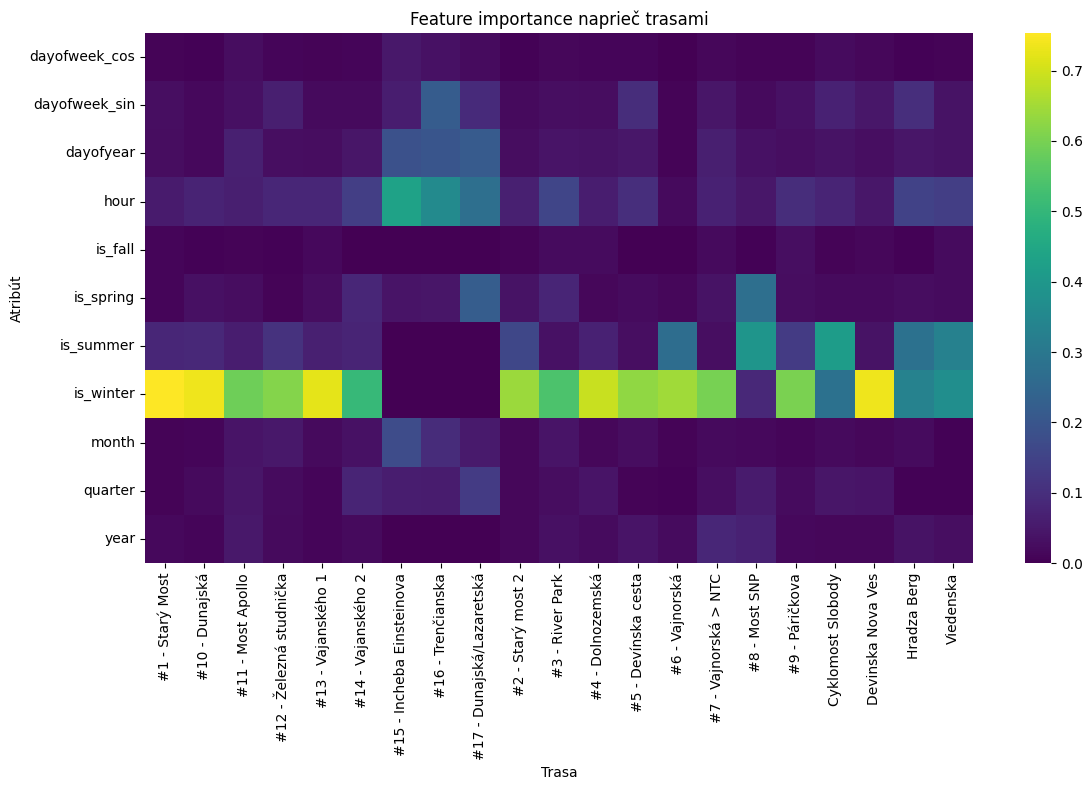

In [104]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_norm,
    cmap='viridis',
    #linewidths=0.3
)
plt.title('Feature importance naprieč trasami')
plt.xlabel('Trasa')
plt.ylabel('Atribút')
plt.tight_layout()
plt.show()


## Testing

In [71]:
test_results = {}

In [72]:
for route in routes:

    route_data = data_with_features[data_with_features["name"] == route].copy()

    DATA = route_data

    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.8*len(DATA))]
    TEST = DATA[int(0.8*len(DATA)):int(len(DATA))]


    X_train = TRAIN[FEATURES_2]
    y_train = TRAIN[TARGET_TOTAL]

    X_val = VALIDATION[FEATURES_2]
    y_val = VALIDATION[TARGET_TOTAL]

    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])

    X_test = TEST[FEATURES_2]
    y_test = TEST[TARGET_TOTAL]

    best_params = best_results_per_route[best_results_per_route['route'] == route].iloc[0]
    n_estimators = best_params['n_estimators']
    learning_rate = best_params['learning_rate']

    MODEL = xgb.XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        eval_metric="mae"
    )

    MODEL.fit(X_train_val, y_train_val, verbose=False)

    y_pred = MODEL.predict(X_test)

    mae = np.mean(np.abs(y_test - y_pred))
    mean_test = y_test.mean()
    rel_mae_test = (mae / mean_test) * 100 if mean_test > 0 else 0

    

    test_results[route] = {
        'mae': mae,
        'rel_mae': rel_mae_test,
        'y_test': y_test.values,
        'y_pred': y_pred
    }

    print(f"Route: {route}, Test MAE: {mae:.4f}, Rel MAE: {rel_mae_test:.4f}")

    

Route: Cyklomost Slobody, Test MAE: 12.4229, Rel MAE: 95.2294
Route: Hradza Berg, Test MAE: 8.0742, Rel MAE: 69.7538
Route: Viedenska, Test MAE: 12.5284, Rel MAE: 54.0777
Route: Devinska Nova Ves, Test MAE: 5.3591, Rel MAE: 104.0658
Route: #1 - Starý Most, Test MAE: 14.3953, Rel MAE: 50.2559
Route: #3 - River Park, Test MAE: 22.8054, Rel MAE: 49.4569
Route: #4 - Dolnozemská, Test MAE: 45.9513, Rel MAE: 59.4207
Route: #5 - Devínska cesta, Test MAE: 7.1025, Rel MAE: 150.3699
Route: #8 - Most SNP, Test MAE: 19.6623, Rel MAE: 90.9811
Route: #9 - Páričkova, Test MAE: 10.7970, Rel MAE: 44.0853
Route: #6 - Vajnorská, Test MAE: 6.7953, Rel MAE: 92.4021
Route: #10 - Dunajská, Test MAE: 9.9488, Rel MAE: 56.3809
Route: #12 - Železná studnička, Test MAE: 25.8871, Rel MAE: 92.6615
Route: #11 - Most Apollo, Test MAE: 27.5138, Rel MAE: 105.9198
Route: #2 - Starý most 2, Test MAE: 11.9247, Rel MAE: 48.5903
Route: #7 - Vajnorská > NTC, Test MAE: 4.8963, Rel MAE: 52.6241
Route: #14 - Vajanského 2, Test 

In [77]:
test_results_df = pd.DataFrame(test_results)

In [ ]:
# for future work if needed
test_results_df.to_csv("XGBoost_val_results")
results_df.to_csv("XGBoost_test_results")

## Plotting Results

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_39752\501592771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


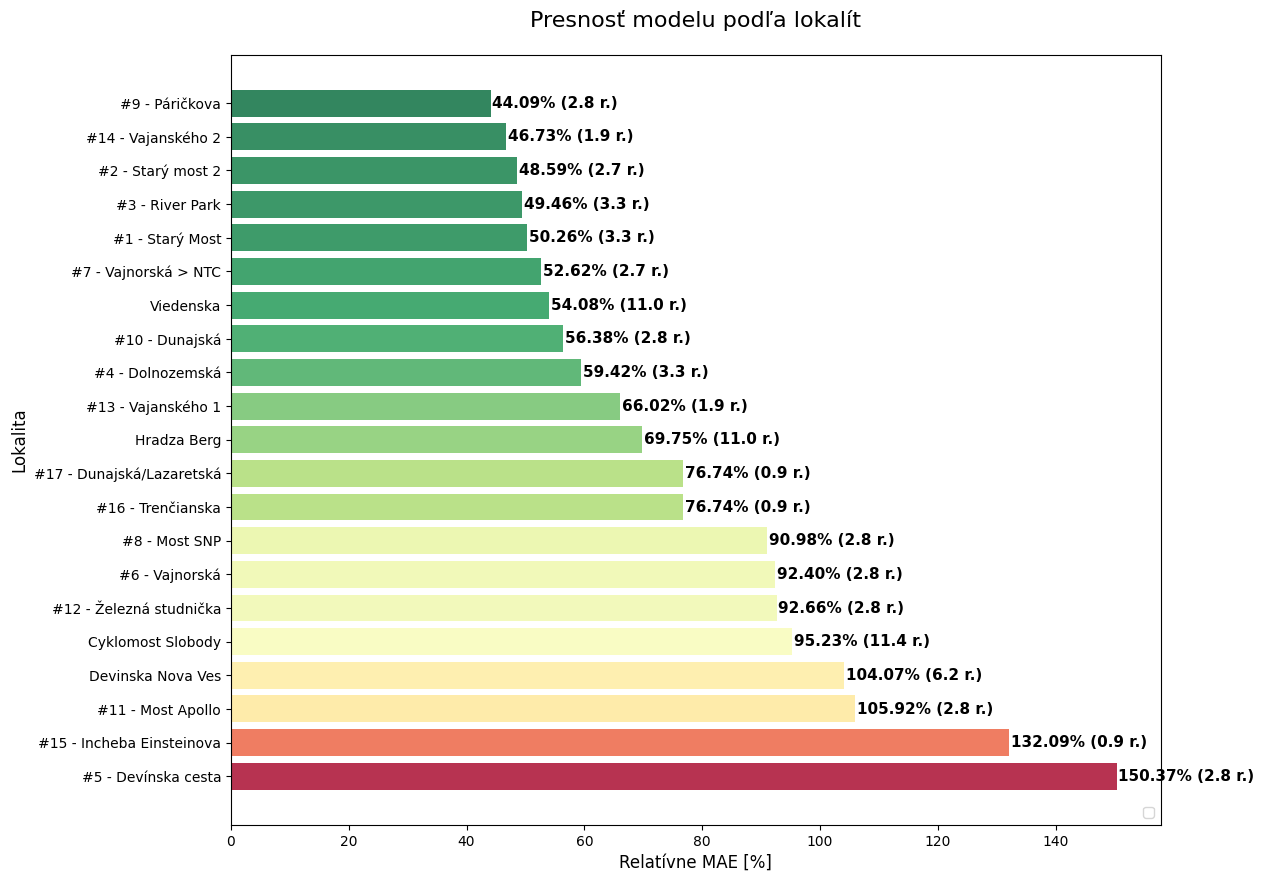

In [108]:

plot_data = []
for route, results in test_results.items():

    route_dates = data_with_features[data_with_features["name"] == route].index
    years_diff = (route_dates.max() - route_dates.min()).days / 365.25
    
    plot_data.append({
        'route': route,
        'rel_mae': results['rel_mae'],
        'years': round(years_diff, 1)
    })

df_plot = pd.DataFrame(plot_data)
df_plot = df_plot.sort_values(by='rel_mae', ascending=False)


plt.figure(figsize=(12, 10))

norm = plt.Normalize(df_plot['rel_mae'].min(), df_plot['rel_mae'].max())
colors = plt.cm.RdYlGn_r(norm(df_plot['rel_mae']))

bars = plt.barh(df_plot['route'], df_plot['rel_mae'], color=colors, alpha=0.8)

for i, bar in enumerate(bars):
    width = bar.get_width()
    years = df_plot.iloc[i]['years']
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}% ({years} r.)', 
             va='center', fontsize=11, fontweight='bold')


plt.title('Presnosť modelu podľa lokalít', fontsize=16, pad=20)
plt.xlabel('Relatívne MAE [%]', fontsize=12)
plt.ylabel('Lokalita', fontsize=12)
plt.legend(loc='lower right')
#plt.grid(axis='x', linestyle=':', alpha=0.5)
#plt.tight_layout()
plt.show()